<a href="https://colab.research.google.com/github/R3gm/Agetic_Data_Analytics/blob/main/X_CLIP_Zero_shot_classify_videos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

We first install 🤗 Transformers, decord and pytube.

In [44]:
!pip install -q git+https://github.com/huggingface/transformers.git decord psutil
!pip install -q -U yt-dlp
!pip -q install langdetect
!pip install -U deep-translator

import torch 
from decord import VideoReader, cpu # issue, decord need first import torch https://github.com/googlecolab/colabtools/issues/500
import numpy as np
from huggingface_hub import hf_hub_download
from PIL import Image
from transformers import XCLIPProcessor, XCLIPModel
import psutil
import os
import re
from langdetect import detect_langs
from langdetect import detect
from deep_translator import GoogleTranslator

def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Vlogs, Tutorials, Product Reviews, Lets Play, Comedy Sketches, Hauls, Educational Content, Unboxing, Challenges, Reaction Videos, Travel Videos, Food and Cooking, Fitness and Workout, Music Covers, Animation

Vlogs, tutoriales, reseñas de productos, Let's Play, esbozos de comedia, compras, contenido educativo, unboxing, desafíos, videos de reacciones, videos de viajes, comida y cocina, fitness y entrenamiento, covers musicales, animación.

correct number of elements
/content
mkdir: cannot create directory ‘youtube.com@probe7828videos’: File exists
/content/youtube.com@probe7828videos
[debug] Command-line config: ['-f', 'bestvideo[height<=450][ext=mp4]+bestaudio[ext=m4a]', '--force-overwrites', '--no-warnings', '--no-abort-on-error', '--ignore-no-formats-error', '-ciw', '-o', '%(title)s.%(ext)s', '-v', 'https://www.youtube.com/@probe7828/videos']
[debug] Encodings: locale UTF-8, fs utf-8, pref UTF-8, out utf-8, error utf-8, screen utf-8
[debug] yt-dlp version stable@2023.03.04 [392389b7d] (pip)
[debug] Python 3.10.11 (CPython x86_64 64bit) - Linux-5.15.107+-x86_64-with-glibc2.31 (OpenSSL 1.1.1f  31 Mar 2020, glibc 2.31)
[debug] exe versions: ffmpeg 4.2.7, ffprobe 4.2.7
[debug] Optional libraries: Cryptodome-3.18.0, brotli-1.0.9, certifi-2022.12.07, mutagen-1.46.0, sqlite3-2.6.0, websockets-11.0.3
[debug] Proxy map: {'colab_language_server': '/usr/colab/bin/language_service'}
[debug] Loaded 1786 extractors
[youtube:tab] Ex

`id2label` is found in both `text_config_dict` and `text_config` but with different values. The value `text_config_dict["id2label"]` will be used instead.


------------------------------------------------------
Lapillus song guessing game and ＂I Love You＂ game (subbed).mp4
Resolution of video:  (32, 360, 640, 3)


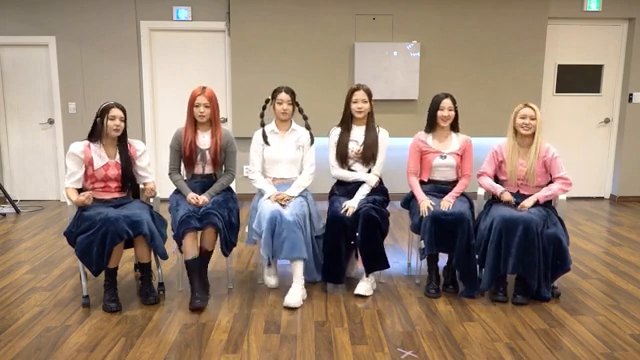

covers musicales 42.75 %
reseñas de productos 11.86 %
esbozos de comedia 11.71 %
comida y cocina 9.99 %
Let's Play 6.73 %
------------------------------------------------------
LAPILLUS in Japan with eng subs.mp4
Resolution of video:  (32, 360, 640, 3)


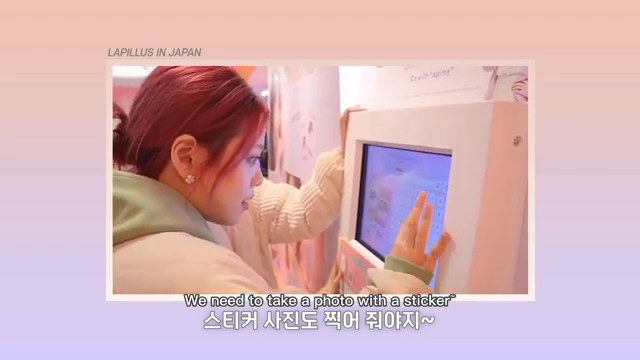

tutoriales 25.53 %
animación. 24.66 %
reseñas de productos 14.18 %
videos de viajes 8.02 %
comida y cocina 5.64 %
------------------------------------------------------
Lapillus Vietnam '2022 Korean Culture an Tourism Fair' Behind the scenes (Eng subbed).mp4
Resolution of video:  (32, 360, 640, 3)


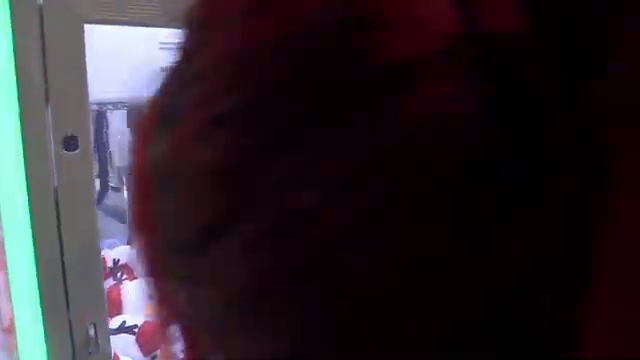

animación. 30.7 %
Vlogs 23.29 %
videos de reacciones 13.62 %
compras 7.85 %
desafíos 5.99 %
------------------------------------------------------
Lapillus '2022 AAA' behind the scenes (subbed).mp4
Resolution of video:  (32, 360, 640, 3)


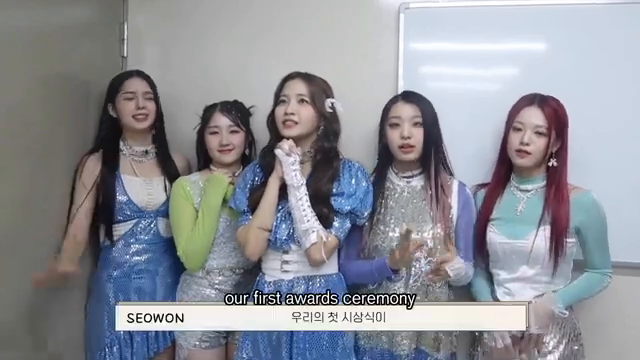

covers musicales 43.67 %
comida y cocina 13.47 %
videos de reacciones 10.44 %
reseñas de productos 6.19 %
animación. 4.14 %
------------------------------------------------------
Lapillus 'SCHOOL ATTACK' Behind the scenes (Eng subbed).mp4
Resolution of video:  (32, 360, 640, 3)


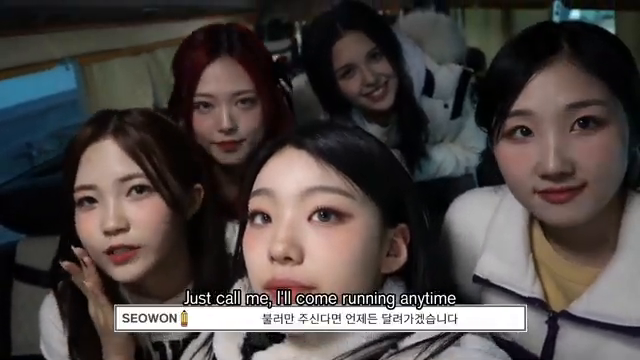

covers musicales 29.62 %
reseñas de productos 12.45 %
comida y cocina 10.65 %
Vlogs 8.23 %
videos de reacciones 6.75 %
------------------------------------------------------
Lapillus interview at OYE 89.7fm video cut with Eng subs.mp4
Resolution of video:  (32, 360, 640, 3)


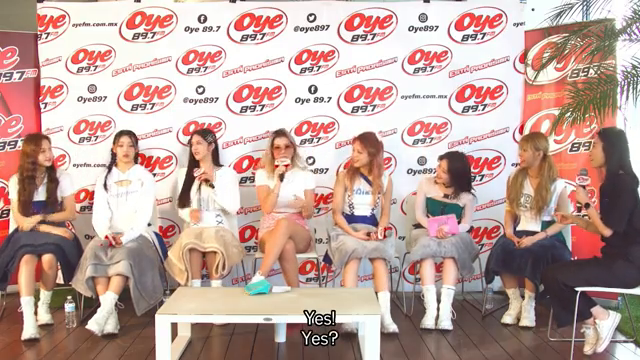

comida y cocina 18.69 %
reseñas de productos 17.44 %
esbozos de comedia 13.21 %
covers musicales 7.53 %
contenido educativo 7.38 %


In [121]:
# Load videos
#@markdown # Enter a link :
youtube_url = 'https://www.youtube.com/@probe7828/videos' #@param {type:"string"}
#@markdown - Download the video from YouTube, it can be playlists or all the videos from a YouTube channel.
#@markdown - List of other supported sites: https://github.com/yt-dlp/yt-dlp/blob/master/supportedsites.md 
# format for download from a channel of youtube https://www.youtube.com/c/somechannel/videos

# text inputs
prompt = "Vlogs, tutoriales, rese\xF1as de productos, Let's Play, esbozos de comedia, compras, contenido educativo, unboxing, desaf\xEDos, videos de reacciones, videos de viajes, comida y cocina, fitness y entrenamiento, covers musicales, animaci\xF3n." #@param {type:"string"}
#@markdown - Select the words separately, with a limit of 16 words, for comma.

detect_lang = detect(prompt)

text_words = []
if detect_lang != 'en':
  for word in prompt.split(','):
    translator_goo =  GoogleTranslator(source=detect_lang, target='en').translate(word) # source = 'auto'
    text_words.append(translator_goo)
  text_words = [item.strip() for item in text_words]
else:
  text_words = [prompt.split(',')]
  text_words = [item.strip() for sublist in text_words for item in sublist]

# for get the original language
prompt = [prompt.split(',')]
prompt = [item.strip() for sublist in prompt for item in sublist]

if len(prompt) == len(text_words):
  print("correct number of elements")
else:
  import os
  os.kill(os.getpid(), 9)



cleaned_url = re.sub(r'[<>:"/\\|?*]', '', youtube_url)

folder = cleaned_url[9:]
folder
%cd /content/
!mkdir {folder}
%cd {folder}

!yt-dlp -f 'bestvideo[height<=450][ext=mp4]+bestaudio[ext=m4a]' --force-overwrites --no-warnings --no-abort-on-error --ignore-no-formats-error -ciw -o "%(title)s.%(ext)s" -v {youtube_url}
# --quiet

# #@markdown # Enter a youtube playlist:
# youtube_url = 'https://www.youtube.com/watch?v=VMj-3S1tku0' #@param {type:"string"}
## other library yt = YouTube(youtube_url)

folder_path = '/content/'+folder
file_path = os.listdir(folder_path)
files = os.listdir(folder_path)
mp4_files = []

print('------------------------------------------------------')
print('Videos: ')
for file in files:
    if file.endswith('.mp4'):
        mp4_files.append(file)
        print(file)
print('------------------------------------------------------')

print('Classes: ', text_words)

print('------------------------------------------------------')

#out
# Load X-CLIP model
# Let's instantiate the XCLIP model, along with its processor.
model_name = "microsoft/xclip-base-patch16-zero-shot"
processor = XCLIPProcessor.from_pretrained(model_name)
model = XCLIPModel.from_pretrained(model_name)

#in
for file in mp4_files:
  print('------------------------------------------------------')
  print(file)
  videoreader = VideoReader(file, num_threads=1, ctx=cpu(0))

  # sample 32 frames
  videoreader.seek(0)
  indices = sample_frame_indices(clip_len=32, frame_sample_rate=4, seg_len=len(videoreader))
  video = videoreader.get_batch(indices).asnumpy()
  print('Resolution of video: ', video.shape)
  videoreader = indices = None

  #Let's visualize the first of the 32 frames!
  #Image.fromarray(video[0])
  image = Image.fromarray(np.uint8(video[28]))
  image.show()

  # Zero-shot classification
  # Usage of X-CLIP is identical to CLIP: you can feed it a bunch of texts, and the model determines which ones go best with the video.
  inputs = processor(text=text_words, videos=list(video), return_tensors="pt", padding=True)
  #video = None = processor

  # forward pass
  with torch.no_grad():
      outputs = model(**inputs)
  # model = None

  probs = outputs.logits_per_video.softmax(dim=1)
  #print(probs)


  probs = probs[0] * 100
  _, indices = torch.sort(probs, descending=True)

  for idx in indices[:5]:
    print(prompt[idx], round((probs[idx].item()),2), '%' )

In [111]:
  with torch.no_grad():
      outputs = model(**inputs)
  # model = None

  probs = outputs.logits_per_video.softmax(dim=1)
  print(probs)

tensor([[0.0351, 0.0039, 0.1529, 0.0241, 0.1799, 0.0089, 0.0629, 0.0053, 0.0246,
         0.0762, 0.0149, 0.0364, 0.1975, 0.0616, 0.1081, 0.0077]])


In [122]:
#probs = probs[0] * 100
_, indices = torch.sort(probs, descending=True)

for idx in indices[:5]:
  print(text_words[idx], round((probs[idx].item()),2), '%' )

food and cooking 18.69 %
product reviews 17.44 %
comedy sketches 13.21 %
musical covers 7.53 %
educational content 7.38 %


In [123]:
_, indices = torch.sort(probs, descending=True)

for idx in indices[:5]:
  print(prompt[idx], round((probs[idx].item()),2), '%' )

comida y cocina 18.69 %
reseñas de productos 17.44 %
esbozos de comedia 13.21 %
covers musicales 7.53 %
contenido educativo 7.38 %


- config output in percenta
- conf a csv output

In [ ]:
from pytube import YouTube
from pytube import Playlist

playlist = Playlist("https://www.youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ").video_urls

for video_link in playlist:
  
    try:
        YouTube(video_link).streams.first().download()
    
    except:
        print(video_link + " unavailable")

In [ ]:
playlist

['https://www.youtube.com/watch?v=VMj-3S1tku0', 'https://www.youtube.com/watch?v=PaCmpygFfXo', 'https://www.youtube.com/watch?v=TCH_1BHY58I', 'https://www.youtube.com/watch?v=P6sfmUTpUmc', 'https://www.youtube.com/watch?v=q8SA3rM6ckI', 'https://www.youtube.com/watch?v=t3YJ5hKiMQ0', 'https://www.youtube.com/watch?v=kCc8FmEb1nY']

In [ ]:
%reset -f

In [ ]:
import sys
sys.getsizeof(processor)

16

In [ ]:
import gc
gc.collect()

553

In [ ]:
all_vars = globals()

In [ ]:
all_vars.keys()

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', 'youtube_url', '_i2', '_exit_code', 'YouTube', 'torch', 'VideoReader', 'cpu', 'gpu', 'np', 'hf_hub_download', 'Image', 'XCLIPProcessor', 'XCLIPModel', 'sample_frame_indices', '_i3', 'yt', 'streams', 'file_path', 'videoreader', 'indices', 'video', 'model_name', 'processor', 'model', 'inputs', 'outputs', 'probs', '_3', '_i4', '_4', '_i5', '_5', '_i6', '_i7', '_i8', 'sys', '_8', '_i9', '_9', '_i10', 'all_vars', '_i11', '_11', '_i12'])

In [ ]:
for var_name, var_value in all_vars.items():
    var_size = sys.getsizeof(var_value)
    print(f"Name: {var_name}, Size: {var_size} bytes") # Value: {var_value}

Name: __name__, Size: 57 bytes
Name: __doc__, Size: 113 bytes
Name: __package__, Size: 16 bytes
Name: __loader__, Size: 16 bytes
Name: __spec__, Size: 16 bytes
Name: __builtin__, Size: 72 bytes
Name: __builtins__, Size: 72 bytes
Name: _ih, Size: 248 bytes
Name: _oh, Size: 232 bytes
Name: _dh, Size: 64 bytes
Name: In, Size: 248 bytes
Name: Out, Size: 232 bytes
Name: get_ipython, Size: 64 bytes
Name: exit, Size: 48 bytes
Name: quit, Size: 48 bytes
Name: _, Size: 28 bytes
Name: __, Size: 49 bytes
Name: ___, Size: 49 bytes
Name: _i, Size: 209 bytes
Name: _ii, Size: 80 bytes
Name: _iii, Size: 209 bytes
Name: _i1, Size: 1638 bytes
Name: youtube_url, Size: 92 bytes
Name: _i2, Size: 835 bytes
Name: _exit_code, Size: 24 bytes
Name: YouTube, Size: 1480 bytes
Name: torch, Size: 72 bytes
Name: VideoReader, Size: 1072 bytes
Name: cpu, Size: 144 bytes
Name: np, Size: 72 bytes
Name: hf_hub_download, Size: 144 bytes
Name: Image, Size: 72 bytes
Name: XCLIPProcessor, Size: 1072 bytes
Name: XCLIPModel, S

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import psutil
import os

pid = os.getpid()
py = psutil.Process(pid)
memory_info = py.memory_info()
print("Before RAM Clearance:", memory_info.rss)
py.kill()
print("hola")

In [ ]:
import psutil
import os

pid = os.getpid()
py = psutil.Process(pid)
memory_info = py.memory_info()
print("Before RAM Clearance:", memory_info.rss)
#py.kill()


Before RAM Clearance: 93548544
